In [19]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.svm import SVC
import GO_utils
import utils
from os import listdir
from os.path import isfile, join

In [20]:
def get_go_terms():
    f_name = '../data/GO_terms_final_gene_counts.txt'
    GO_counts_file = open(f_name)

    terms = []
    for (i, line) in enumerate(GO_counts_file):
        if i < 2:
            continue
        term = line.split('\t')[0]
        terms.append(term)
    return terms

def get_tissue_list(tissue_fpath):
    tissue_file = open(tissue_fpath)
    for line in tissue_file:
        tissues = line.rstrip().split('\t')
        break
    return tissues

def get_1_tissue_aucs(GO_term, tissue_list):
    """
    This function gets the AUC scores of predicting the gene associations of 
    |GO_term| where each prediction task only used features from an individual
    tissue.
    
    :param GO_term: The GO term
    :param tissue_list: List of tissues that were used for separate prediction
    tasks. If len(tissue_list)=53, then we performed 53 separate prediciton
    problems, where each prediction problem used a different 1 of the 53 tissues.
    :return: A list of AUC scores in the same order as |tissue_list|. The ith element in this
    list is the AUC score for predicting this GO term using only tissue i.
    """
    
    aucs_1_tissue = []
    results_dir = 'results_1_tissue/' + GO_term + '/'
    for tissue in tissue_list:
        # Get the AUC score when using features from only this tissue
        f_name = results_dir + 'logreg_' + tissue + '.txt'
        rf = open(f_name)
        for (i, line) in enumerate(rf):
            if i == 2:
                auc_score = float(line.split(' ')[-1])
                aucs_1_tissue.append(auc_score)
            elif i > 2:
                break
    return aucs_1_tissue

def get_all_1_tissue_aucs(GO_terms, tissue_list):
    aucs = np.zeros(shape=(len(GO_terms),len(tissue_list)))  # aucs[i][j] is auc score for using jth tissue features to predict ith GO term
    for (i, term) in enumerate(GO_terms):
        aucs[i, :] = get_1_tissue_aucs(term, tissue_list)
    return aucs

#def get_all_feature_aucs():

In [86]:
def map_GO_to_GTEX():
    inputFilename = '../data/GO_terms_final_gene_counts.txt'
    GO_list_file = open(inputFilename)
    GO_list = np.loadtxt(GO_list_file,skiprows=2,usecols=[0],dtype='S10',delimiter='\t')
    
    inputFilename = '../data/Tissue_Name_Mappings.csv'
    tissue_data = pd.read_csv(inputFilename,header=None)
    map_BTO_to_GTEX = defaultdict(list)

    for index,row in tissue_data.iterrows():
        GTEX_tissue = row[0]
        BTO_tissues = row[1:]
        for tissue in BTO_tissues.dropna():
            map_BTO_to_GTEX[tissue].append(GTEX_tissue)

    inputFilename = '../data/BTO_GO.csv'
    BTO_data = pd.read_csv(inputFilename,skiprows=[0])
    map_GO_to_GTEX = defaultdict(list)

    for index,row in BTO_data.iterrows():
        tissue = row[1]
        if tissue in map_BTO_to_GTEX:
            GO_IDs = row[2:]
            for GO_ID in GO_IDs.dropna():
                if GO_ID in GO_list:
                    map_GO_to_GTEX[GO_ID] = list(set(map_GO_to_GTEX[GO_ID] + map_BTO_to_GTEX[tissue]))

    #inputFile.close()
    return map_GO_to_GTEX

def map_GTEX_to_GO(map_GO_to_GTEX):
    GTEX_to_GO = defaultdict(list)
    for GO_ID,tissues in map_GO_to_GTEX.items():
        for tissue in tissues:
            if GO_ID not in GTEX_to_GO[tissue]:
                GTEX_to_GO[tissue].append(GO_ID)
    return GTEX_to_GO
   
def map_GTEX_to_cols(dir_path, tissues):
    GTEX_to_samples = {}
    for tissue in tissues:
        cols = []
        fpath = dir_path + 'tissue_meta_' + tissue + '.txt'
        meta_file = open(fpath)
        for (i, line) in enumerate(meta_file):
            if i < 1:
                continue
            else:
                cols.append(int(line.split('\t')[0]))
        GTEX_to_samples[tissue] = cols
        meta_file.close()
    return GTEX_to_samples

In [93]:
def make_boxplot(vals, labels):
    plt.figure(figsize=(18, 6))
    plt.margins(0.01)
    plt.ylim([0, 1])
    ax = plt.gca()
    ax.xaxis.grid(which='both')
    plt.xticks(range(len(labels)), labels, rotation='vertical')
    ax.boxplot(vals, labels=labels)
    plt.show()

In [165]:
GO_terms = get_go_terms()
all_tissues = get_tissue_list('../data/tissues.txt')
aucs = get_all_1_tissue_aucs(GO_terms, all_tissues)

## AUC Score Distribution Using Features from Individual Tissues (Tissues not ordered)

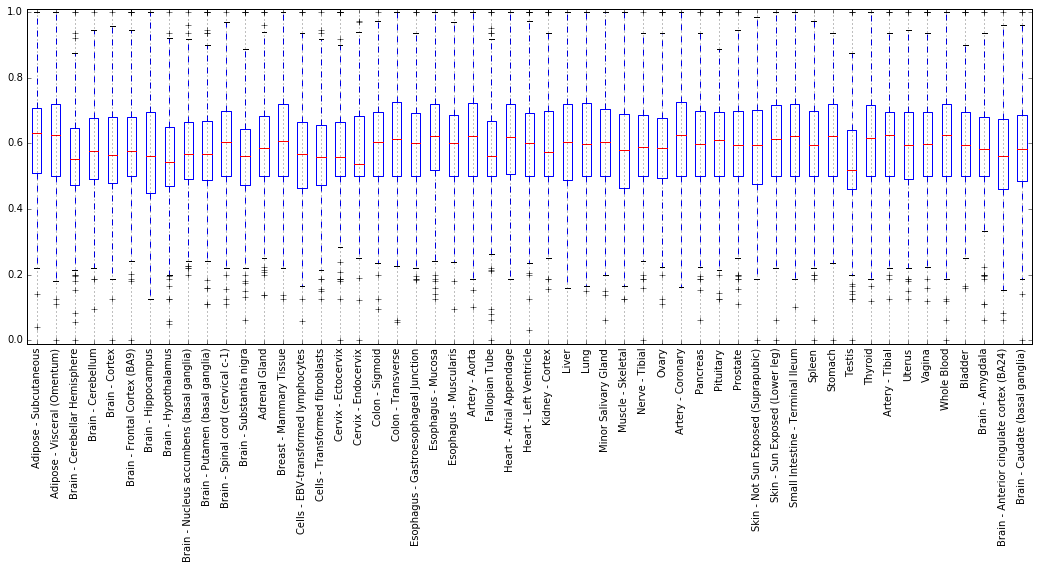

In [89]:
make_boxplot(aucs, all_tissues)

## Sort tissues by number of Samples

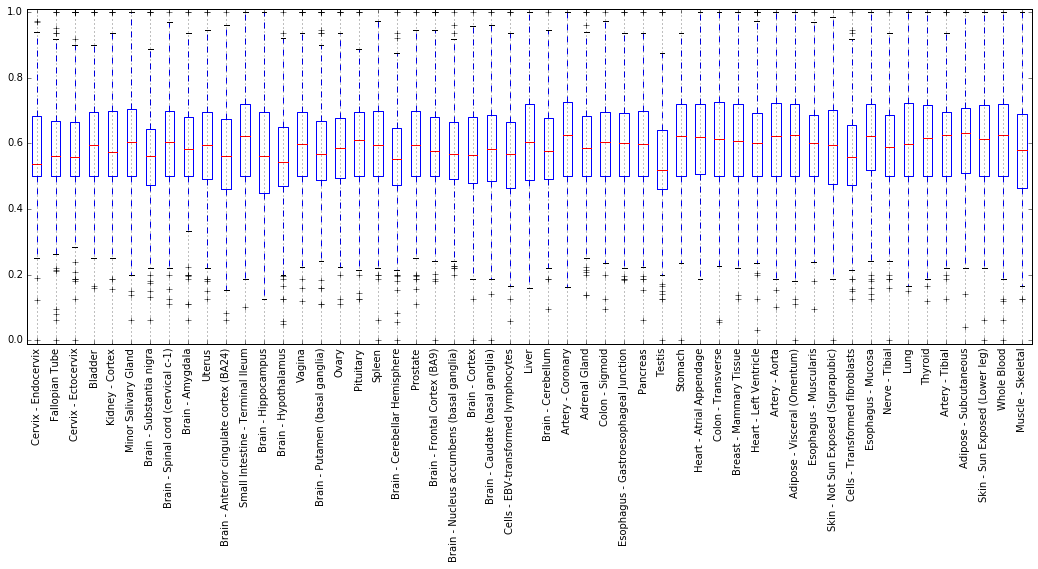

In [90]:
GTEX_to_cols = map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order
tissues_sorted_samp = np.array(all_tissues)[index_order]
aucs_sorted_samp = np.transpose(np.transpose(aucs)[index_order])

make_boxplot(aucs_sorted_samp, tissues_sorted_samp)

## Sort tissues by number of GO terms

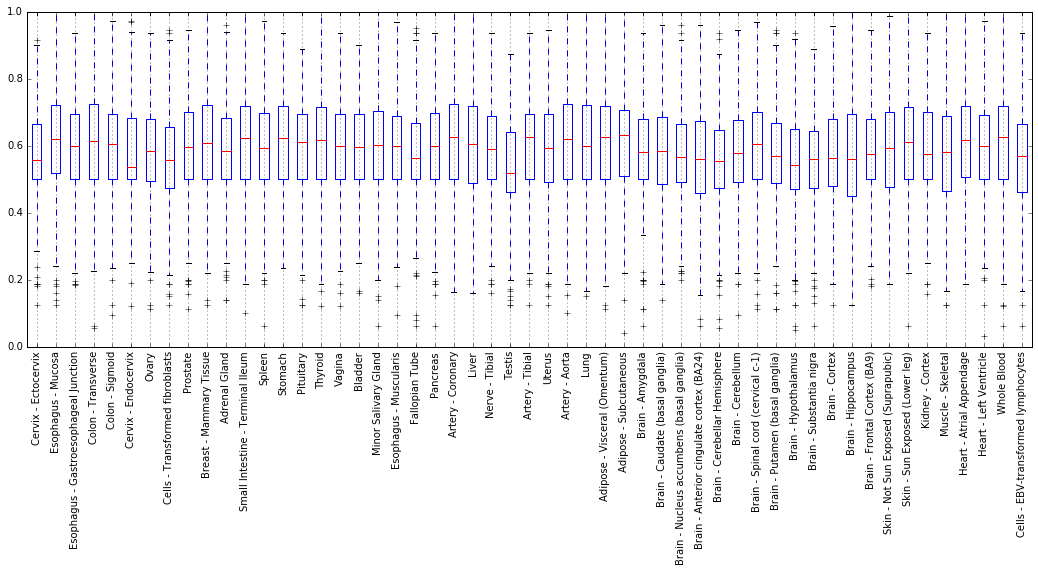

In [168]:
GO_to_GTEX = map_GO_to_GTEX()
GTEX_to_GO = map_GTEX_to_GO(GO_to_GTEX)
            
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted_GO = np.array(all_tissues)[index_order]
aucs_sorted_GO = np.transpose(np.transpose(aucs)[index_order])

make_boxplot(aucs_sorted_GO, tissues_sorted_GO)

## AUC Distributions using only those GO terms specific to the tissue (sort by # GO terms)

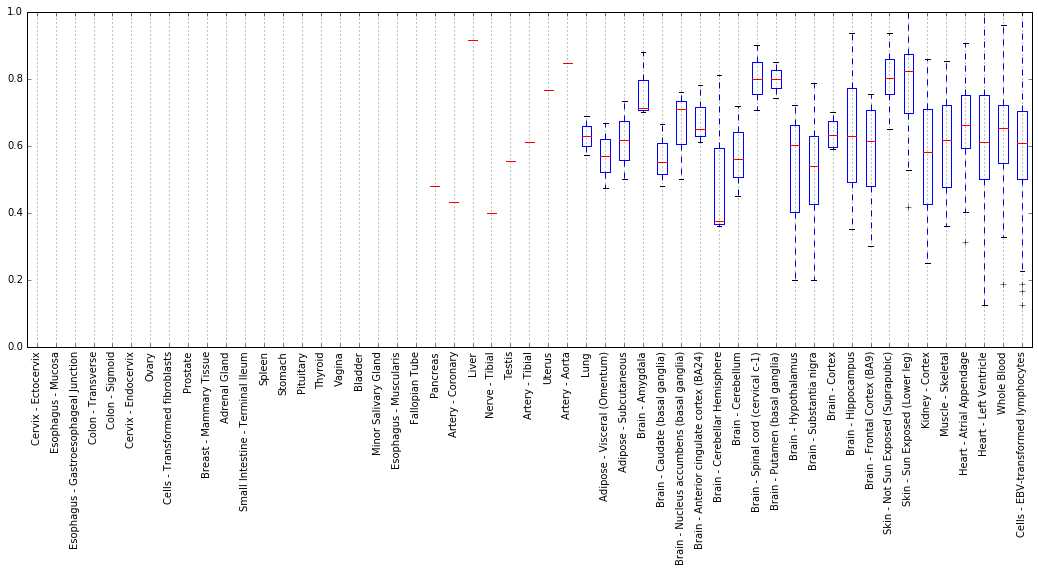

In [169]:
# For each tissue, get the AUC of each GO term that is associated with it.
aucs_spec = []
for tissue in all_tissues:
    terms = GTEX_to_GO[tissue]
    aucs_spec.append(get_all_1_tissue_aucs(terms, [tissue]))
    
# Sort tissues by number of GO terms
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted = np.array(all_tissues)[index_order]
aucs_spec_sorted = np.array(aucs_spec)[index_order]
   
make_boxplot(aucs_spec_sorted, tissues_sorted)

## AUC Distributions using only those GO terms specific to the tissue (sort by # samples)

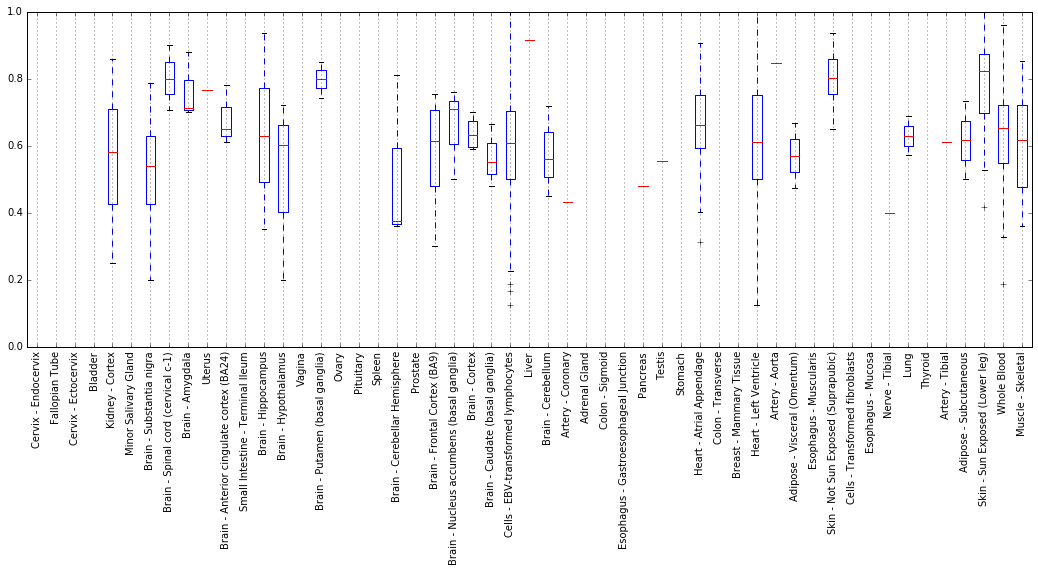

In [170]:
GTEX_to_cols = map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order
tissues_spec_sorted_samp = np.array(all_tissues)[index_order]
aucs_spec_sorted_samp = np.transpose(np.transpose(aucs_spec)[index_order])

make_boxplot(aucs_spec_sorted_samp, tissues_spec_sorted_samp)

In [167]:
print all_tissues[39]
terms = GTEX_to_GO[all_tissues[39]]
print terms
print get_all_1_tissue_aucs(GO_terms, [all_tissues[39]])

Skin - Sun Exposed (Lower leg)
['GO:0045606', 'GO:0045682', 'GO:0008544', 'GO:0033561', 'GO:0045684', 'GO:0045604', 'GO:0043588', 'GO:0009913']
[[ 0.66551611]
 [ 0.70491803]
 [ 0.63430049]
 [ 0.6802093 ]
 [ 0.55200501]
 [ 0.44106622]
 [ 0.6052    ]
 [ 0.66518519]
 [ 0.635     ]
 [ 0.73753463]
 [ 0.76246537]
 [ 0.65789474]
 [ 0.54501385]
 [ 0.57548476]
 [ 0.61723886]
 [ 0.55591837]
 [ 0.7578125 ]
 [ 0.58398438]
 [ 0.68314256]
 [ 0.74      ]
 [ 0.56064209]
 [ 0.64039409]
 [ 0.5127551 ]
 [ 0.66642012]
 [ 0.62204142]
 [ 0.71745562]
 [ 0.6832    ]
 [ 0.43055556]
 [ 0.87901701]
 [ 0.60850694]
 [ 0.75413223]
 [ 0.63119835]
 [ 0.5       ]
 [ 0.625     ]
 [ 0.49      ]
 [ 0.5       ]
 [ 0.5547619 ]
 [ 0.47619048]
 [ 0.485     ]
 [ 0.51125   ]
 [ 0.57407407]
 [ 0.58918129]
 [ 0.66959064]
 [ 0.72530864]
 [ 0.76297578]
 [ 0.62283737]
 [ 0.64705882]
 [ 0.72685185]
 [ 0.55709343]
 [ 0.75778547]
 [ 0.4453125 ]
 [ 0.44726562]
 [ 0.71484375]
 [ 0.49609375]
 [ 0.6875    ]
 [ 0.47460938]
 [ 0.57555556]
 

In [171]:
def get_emp_cdf(arr, num_bins=53):
    # Get the empirical CDF of |arr|
    cumfreqs, _, _, _ = cumfreq(arr, num_bins, defaultreallimits=(0,num_bins+0.1))
    return (1.0 / arr.shape[1]) * cumfreqs  # Normalize the frequencies so that the max is 1

## "CDF" Curves. Ex: For X% of Associated GO terms, blood features are in the top N AUC Scores.

0 101


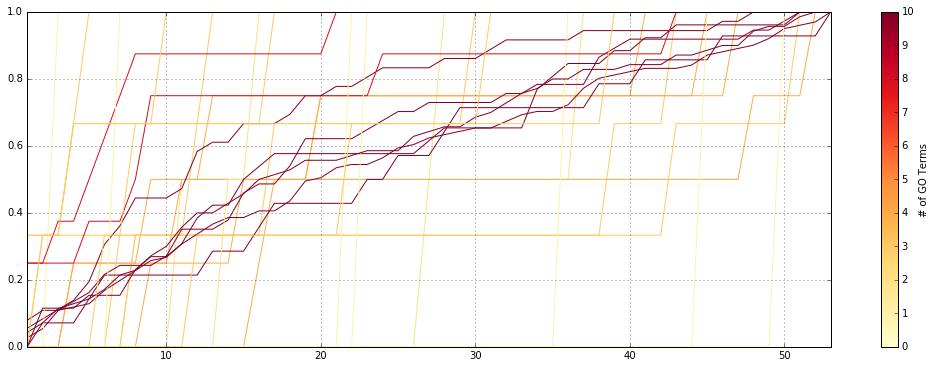

In [173]:
cmap = plt.cm.YlOrRd
GO_counts = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
min_count = min(GO_counts)
max_count = max(GO_counts)
print min_count, max_count
scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_count, vmax=max_count/10))


aucs_spec = []
for tissue in all_tissues:
    terms = GTEX_to_GO[tissue]
    aucs_spec.append(get_all_1_tissue_aucs(terms, [tissue]))
    

num_tissues = len(all_tissues)
num_GO_terms_total = aucs.shape[0]

plt.figure(figsize=(18, 6))
ax = plt.gca()
plt.ylim([0,1])
plt.xlim([1, num_tissues])

for i, tissue in enumerate(all_tissues):
    assoc_rows = []  # rows of GO terms associated w/this tissue
    for term in GTEX_to_GO[tissue]:
        assoc_rows.append(GO_terms.index(term))
    assoc_rows = sorted(assoc_rows)
    
    if len(assoc_rows) == 0:
        continue
        
    tissue_rankings = np.zeros(shape=(1,len(assoc_rows)))
    idx = 0
    for j, row in enumerate(aucs): # for each GO term
        if j in assoc_rows:  # this row's GO term in associated with this tissue
            cur_auc = row[i]  # ith tissue's AUC score for this GO term
            cur_ranking = 1 + sum(a > cur_auc for a in row)
            tissue_rankings[0,idx] = cur_ranking
            idx += 1
    
    emp_cdf = get_emp_cdf(tissue_rankings, num_bins=num_tissues)
    colorVal = scalarMap.to_rgba(GO_counts[i])  # color by # of GO terms assoc w/this tissue
    ax.plot(range(1,num_tissues+1), emp_cdf, color=colorVal)

# Generate colorbar
scalarMap.set_array([])  # You have to set a dummy-array for this to work...
cbar = plt.colorbar(scalarMap)
cbar.set_label('# of GO Terms')    

ax.grid()
plt.show()

## "CDF" Curves. Ex: For X% of All GO terms, blood features are in the top N AUC Scores.

0 101


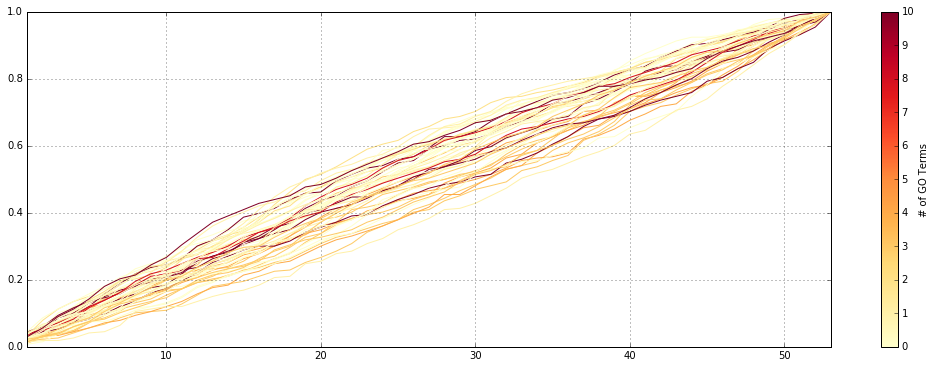

In [174]:
"""
aucs matrix is already built: gives auc for a given tissue and GO term
for each tissue:
    for each go term:
        ranking of this tissue's AUC for this GO term
rankings = [1, 20, 4, 12]  # rankings for each GO term of a particular tissue
plot cdf

color by # of GO terms
"""
cmap = plt.cm.YlOrRd
GO_counts = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
min_count = min(GO_counts)
max_count = max(GO_counts)
print min_count, max_count
scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_count, vmax=max_count/10))

num_tissues = len(all_tissues)
num_GO_terms = aucs.shape[0]

plt.figure(figsize=(18, 6))
ax = plt.gca()
plt.ylim([0,1])
plt.xlim([1, num_tissues])

for i, tissue in enumerate(all_tissues):
    tissue_rankings = np.zeros(shape=(1,num_GO_terms))
    for j, row in enumerate(aucs): # for each GO term
        cur_auc = row[i]  # ith tissue's AUC score for this GO term
        cur_ranking = 1 + sum(a > cur_auc for a in row)
        tissue_rankings[0,j] = cur_ranking
    
    emp_cdf = get_emp_cdf(tissue_rankings, num_bins=num_tissues)
    colorVal = scalarMap.to_rgba(GO_counts[i])  # color by # of GO terms assoc w/this tissue
    ax.plot(range(1,num_tissues+1), emp_cdf, color=colorVal)

# Generate colorbar
scalarMap.set_array([])  # You have to set a dummy-array for this to work...
cbar = plt.colorbar(scalarMap)
cbar.set_label('# of GO Terms')    

ax.grid()
plt.show()

(NOTE: this section is not yet complete. I probably won't complete it b/c the above cdf curves contain more info). 

Generate stacked bar plot. Each tissue should have a stack. The top of the nth stack represents the fraction of the time that this tissue was among the nth best predictors for a GO term that is annoted with this tissue.

In [ ]:
num_stacks = 3
mat = np.zeros(shape=())

In [91]:
# For each GO term, generate a list of tissues in order of their AUC scores for this GO term
GO_best_predictors = {}
for term in GO_terms:
    aucs = get_1_tissue_aucs(term, tissues_sorted)
    best_tissue_idxs = np.argsort(aucs)[::-1]
    GO_best_predictors[term] = np.array(tissues_sorted)[best_tissue_idxs[0:num_stacks]]

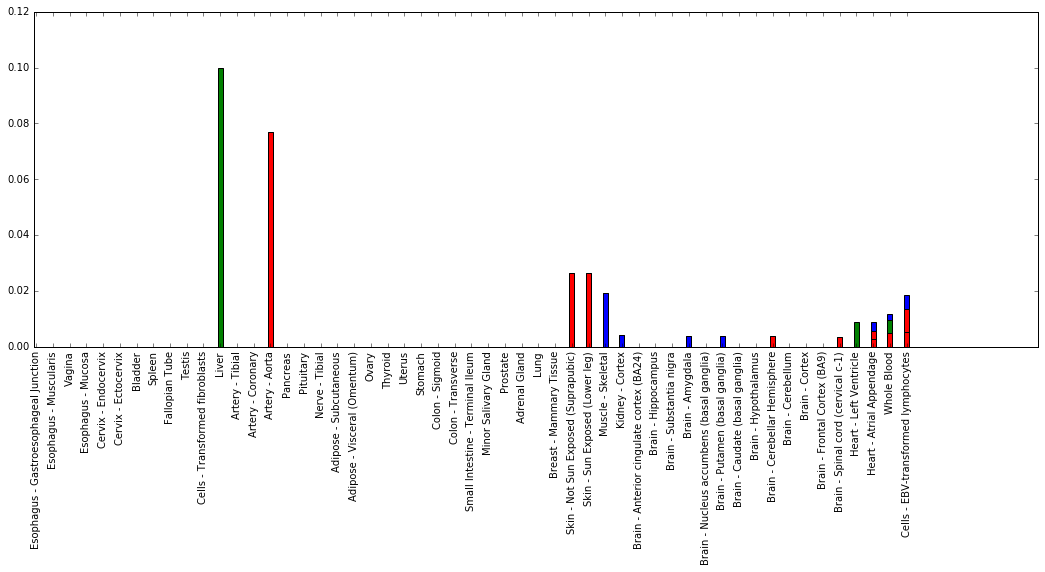

In [127]:
num_stacks = 3
aucs_sorted_top3 = np.zeros(shape=(len(tissues_sorted), num_stacks))

# For each tissue, determine fraction of time it results in a top AUC score for its 
# associated GO terms
for (i, tissue) in enumerate(tissues_sorted):
    GO_assoc = GTEXmap[tissue] # associated GO terms
    fracs = np.zeros(shape=(1, num_stacks))
    for term in GO_assoc:
        # TODO: figure out why some terms in GO_assoc are not in GO_best_predictors
        if term in GO_best_predictors:
            top_tissues = GO_best_predictors[term][0:num_stacks]
            if tissue in top_tissues:
                tiss_index = np.where(top_tissues == tissue) #top_tissues.index(tissue)
                fracs[0, tiss_index] += 1
    fracs *= (1.0 / len(GO_assoc))
    aucs_sorted_top3[i, :] = fracs

plt.figure(figsize=(18, 6))
ax = plt.gca()
idx = range(0, len(tissues_sorted))
width = 0.3
# colors
colors = ['red', 'blue', 'green']
for (i, row) in enumerate(np.transpose(aucs_sorted_top3)):
    if i==0:
        ax.bar(idx, row, width, color=colors[i])
    else:
        ax.bar(idx, row, width, color=colors[i],
             bottom=prev_top)
    prev_top = row

plt.xticks(range(len(tissues_sorted)), tissues_sorted, rotation='vertical')
ax.set_xticks(np.arange(len(tissues_sorted)) + 0.3/2.)
plt.show()

1.0


/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


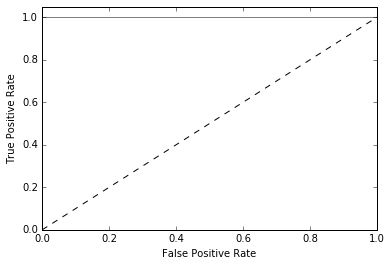

In [80]:
# Why does this get an AUC of 1 ??
#  GO:0033561 using only skin sun exposed
labels_ = [0, 1, 1, 0, 0, 1, 0, 0, 1]
p_prob = [0.000384567351229, 0.999999999702, 0.999998206652, 0.159726368778, 0.192961997394, 0.472920036517, 0.0170798368776, 0.0291811896014, 0.999999999327]
print roc_auc_score(labels_, p_prob)

cur_fpr, cur_tpr, _ = roc_curve(labels_, p_prob)
        
plt.plot(cur_fpr, cur_tpr, 'gray')
plt.plot([0, 1], [0, 1], 'k--')  # Plot the 50% line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [65]:
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.9, 0.9, 0.9, 0.9])
roc_auc_score(y_true, y_scores)

0.5

[ 0.57142857  0.71428571  0.85714286  0.85714286  0.85714286  1.        ]


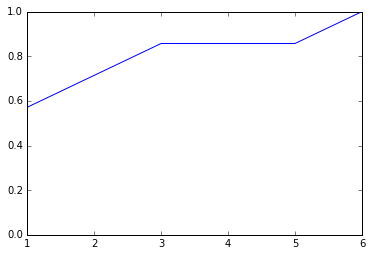

In [131]:
from scipy.stats import cumfreq
a = np.array([[1, 2, 1, 3, 1, 1, 6]])
emp_cdf = get_emp_cdf(a, num_bins=6)
print emp_cdf
plt.plot(range(1,7), emp_cdf)
plt.ylim([0,1])
plt.show()